# Plot MFT prediction of input response of unstructured network

For inputs to all, single, or $Q$ populations, as function of $D$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import sys

from disp import set_plot

from ntwk import SoftmaxNtwk

In [2]:
N = 200
G = np.inf
NTRIAL = 3
U_SCALES = np.arange(0, 12.5, 0.5)
T_MAX = 21
t = np.arange(T_MAX)
t_u = 5

DS = [2, 3, 4, 8, 20, 50]
NPPLN_STIMS = [1, 2, 4, 'all']

In [3]:
PLOT = False

fr_1s = np.nan*np.zeros((len(NPPLN_STIMS), len(DS), NTRIAL, len(U_SCALES)))  # firing rate of first co-tuned ppln

for cD, D in enumerate(DS):
    sys.stdout.write(f'\nD = {D}: ')
    
    # ppln level weights
    MU_J = np.zeros((D, D))
    SGM_J = np.ones((D, D))

    # full weight matrices
    J = np.nan*np.zeros((D, D, N, N))

    for d_to in range(D):
        for d_from in range(D):
            J[d_to, d_from, :, :] = SGM_J[d_to, d_from]*np.sqrt(D/N)*np.random.randn(N, N) + MU_J[d_to, d_from]*D/N

    ntwk = SoftmaxNtwk(J)
    
    th_0 = 1 + np.random.randn(D)*.01
    th_0 /= th_0.sum()
    
    for cNPPLN_STIM, NPPLN_STIM in enumerate(NPPLN_STIMS):
        sys.stdout.write(f'NPPLN_STIM = {NPPLN_STIM}; ')
    
        u_base = np.zeros((N, D))
        
        if NPPLN_STIM == 'all':
            u_base[:, :] = 1
        elif NPPLN_STIM > D:
            fr_1s[cNPPLN_STIM, cD, :, :] = np.nan
            continue
        else:
            u_base[:, :NPPLN_STIM] = 1
            
        ths_alls = []

        for cu_scale, u_scale in enumerate(U_SCALES):

            ths_all = []
            
            us = {t_: u_scale*u_base for t_ in range(t_u, T_MAX)}

            for cTRIAL in range(NTRIAL):

                ths = np.nan*np.zeros((T_MAX, D))
                ths[0, :] = th_0

                x_0 = np.random.randn(N, D)
                g = np.inf
                
                _, xs, ys = ntwk.run(g=g, t_max=T_MAX, x_0=x_0, us=us)
                
                ths = ys.mean(axis=1)

                ths_all.append(ths)
                
                fr_1s[cNPPLN_STIM, cD, cTRIAL, cu_scale] = ths[t_u:, 0].mean()

            ths_alls.append(ths_all)
            
        if PLOT:
            fig, axs = plt.subplots(2, len(U_SCALES), figsize=(2*len(U_SCALES), 4), tight_layout=True, sharex=True, sharey=True)

            for ths_all, ax_col in zip(ths_alls, axs.T):
                for cTRIAL, (ths, ax) in enumerate(zip(ths_all, ax_col)):
                    ax.plot(ths)
                    ax.axvspan(t_u, T_MAX, color='gray', alpha=.15)

                    if ax is axs[-1]:
                        ax.set_xlabel('Time')

                    title = f'MFT (D={D}, Trial {cTRIAL})\nSTIM {NPPLN_STIM} PPLNS'
                    set_plot(ax, x_ticks=np.arange(0, T_MAX, 10), y_label='Firing rate', title=title)


D = 2: NPPLN_STIM = 1; NPPLN_STIM = 2; NPPLN_STIM = 4; NPPLN_STIM = all; 
D = 3: NPPLN_STIM = 1; NPPLN_STIM = 2; NPPLN_STIM = 4; NPPLN_STIM = all; 
D = 4: NPPLN_STIM = 1; NPPLN_STIM = 2; NPPLN_STIM = 4; NPPLN_STIM = all; 
D = 8: NPPLN_STIM = 1; NPPLN_STIM = 2; NPPLN_STIM = 4; NPPLN_STIM = all; 
D = 20: NPPLN_STIM = 1; NPPLN_STIM = 2; NPPLN_STIM = 4; NPPLN_STIM = all; 
D = 50: NPPLN_STIM = 1; NPPLN_STIM = 2; NPPLN_STIM = 4; NPPLN_STIM = all; 

/Users/rp21/opt/miniconda3/envs/sci/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


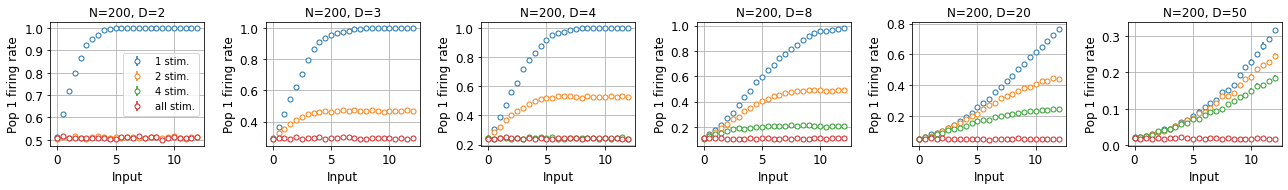

In [4]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(1, len(DS), figsize=(3*len(DS), 2.75), tight_layout=True)
for cD, (D, ax) in enumerate(zip(DS, axs)):
    for cNPPLN_STIM, NPPLN_STIM in enumerate(NPPLN_STIMS):
        ax.errorbar(
            U_SCALES, fr_1s[cNPPLN_STIM, cD, :, :].mean(0),
            yerr=fr_1s[cNPPLN_STIM, cD, :, :].std(0), fmt='o', mfc='w', ms=5)
    ax.grid()
    set_plot(ax, x_label='Input', y_label='Pop 1 firing rate', title=f'N={N}, D={D}')
    if cD == 0:
        ax.legend([f'{NPPLN_STIM} stim.' for NPPLN_STIM in NPPLN_STIMS])

In [5]:
np.save('data/input_response/full_input_rsp.npy', np.array([
    {
        'NPPLN_STIMS': NPPLN_STIMS,
        'DS': DS,
        'U_SCALES': U_SCALES,
        'N': N,
        'NTRIAL': NTRIAL,
        'fr_1s': fr_1s,
    }
]))